In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/dataset/224'

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_samples = np.bincount(train_generator.classes)
total_samples = len(train_generator.classes)
class_weights = total_samples / (train_generator.num_classes * class_samples)
class_weight_dict = {class_id: weight for class_id, weight in enumerate(class_weights)}

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Found 275 images belonging to 3 classes.
Found 67 images belonging to 3 classes.
87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)

model = Model(base_model.input, output)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/30
9/9 [==============================] - 54s 5s/step - loss: 1.5611 - accuracy: 0.5600 - val_loss: 0.6611 - val_accuracy: 0.7910
Epoch 2/30
9/9 [==============================] - 1s 114ms/step - loss: 0.5339 - accuracy: 0.8509 - val_loss: 0.6822 - val_accuracy: 0.7910
Epoch 3/30
9/9 [==============================] - 2s 192ms/step - loss: 0.3619 - accuracy: 0.9127 - val_loss: 0.2660 - val_accuracy: 0.9254
Epoch 4/30
9/9 [==============================] - 1s 156ms/step - loss: 0.2467 - accuracy: 0.9491 - val_loss: 0.2575 - val_accuracy: 0.9552
Epoch 5/30
9/9 [==============================] - 1s 121ms/step - loss: 0.2286 - accuracy: 0.9491 - val_loss: 0.2574 - val_accuracy: 0.9403
Epoch 6/30
9/9 [==============================] - 1s 121ms/step - loss: 0.1494 - accuracy: 0.9745 - val_loss: 0.2643 - val_accuracy: 0.9552
Epoch 7/30
9/9 [==============================] - 1s 120ms/step - loss: 0.1481 - accuracy: 0.9709 - val_loss: 0.2765 - val_accuracy: 0.9403
Epoch 8/30
9/9 [======

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

output_dir = '/content/drive/MyDrive/Colab Notebooks/output/output_googlenet'
os.makedirs(output_dir, exist_ok=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(output_dir, 'accuracy_plot.png'))
plt.close()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(output_dir, 'loss_plot.png'))
plt.close()

test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

test_results = model.evaluate(test_generator, steps=len(test_generator))
with open(os.path.join(output_dir, 'metrics.txt'), 'w') as results_file:
    results_file.write(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}\n\n")

    class_labels = ['Normal', 'Scol', 'Spond']

    class_report = classification_report(y_true, y_pred, target_names=class_labels)
    results_file.write("Classification Report for Three-Class Classification:\n")
    results_file.write(class_report + "\n")

    conf_matrix = confusion_matrix(y_true, y_pred)
    results_file.write("Confusion Matrix for Three-Class Classification:\n")
    results_file.write(str(conf_matrix) + "\n")

    for i, label in enumerate(class_labels):
        tn = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        fp = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
        specificity = tn / (tn + fp)
        results_file.write(f"\nSpecificity for {label} in Three-Class Classification: {specificity}\n")

    accuracy = accuracy_score(y_true, y_pred)
    results_file.write(f"\nAccuracy for Three-Class Classification: {accuracy}\n")

model.save(os.path.join(output_dir, 'saved_model.h5'))

Found 67 images belonging to 3 classes.
3/3 [==============================] - 0s 67ms/step - loss: 0.2893 - accuracy: 0.9552


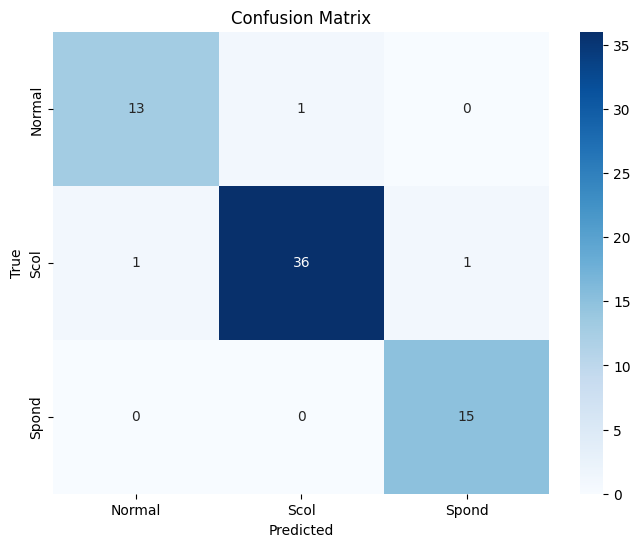

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
confusion_matrix_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path)
plt.show()

with open(os.path.join(output_dir, 'metrics.txt'), 'a') as results_file:
    results_file.write(f"Confusion Matrix saved at: {confusion_matrix_path}\n")

1/1 [==============================] - 0s 80ms/step
Prediction result saved at: /content/drive/MyDrive/Colab Notebooks/output/prediction_result_Normal_correct.png
Model saved at: /content/drive/MyDrive/Colab Notebooks/output/saved_model.h5


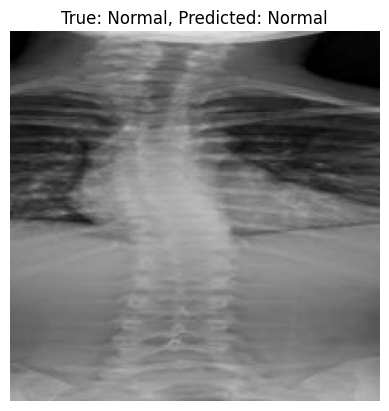

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

test_image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/224/Normal/N67,N,21,F_1_0.jpg'

input_image = load_and_preprocess_image(test_image_path)
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)

true_class = test_image_path.split(os.path.sep)[-2]

class_labels = ['Normal', 'Scol', 'Spond']

img = image.load_img(test_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')

result_label = 'correct' if class_labels[predicted_class] == true_class else 'wrong'
result_image_name = f"prediction_result_{true_class}_{result_label}.png"
result_image_path = os.path.join(output_dir, result_image_name)

plt.title(f"True: {true_class}, Predicted: {class_labels[predicted_class]}")
plt.savefig(result_image_path)

prediction_result_path = result_image_path

print(f"Prediction result saved at: {prediction_result_path}")